In [1]:
import pyvista as pv
from Kirchhoffpy import lenspy
from Kirchhoffpy import Feedpy
import matplotlib.pyplot as plt
import numpy as np
import torch as T
from Kirchhoffpy import coordinate,field_storage
from Kirchhoffpy.Vopy import CO,dotproduct

#mu=4*np.pi*10**(-7)
#epsilon=8.854187817*10**(-12)
#Z0=np.sqrt(mu/epsilon,dtype = np.float64)
p = pv.Plotter()
srffolder = 'srf2/'


10


In [2]:
# 1. define frequnecy and wavelength
c=299792458
freq = 90*10**9
Lambda = c*1000/freq
k = 2*np.pi/Lambda
print(Lambda,k)


3.3310273111111113 1.8862605197565134


In [3]:
# 2. define coordinate systems
coord_ref = coordinate.coord_sys([0,0,0],[0,0,0],axes = 'xyz')
#-(844.621988-4.34990822154231*10)
coord_L1 = coordinate.coord_sys([0,0,-(844.621988-4.349908*10)],[np.pi,0,0],axes = 'xyz',ref_coord = coord_ref)

coord_feed = coordinate.coord_sys([0,0,0],[np.pi,0,0],axes = 'xyz',ref_coord = coord_ref)

coord_sky = coordinate.coord_sys([0,0,0],[np.pi,0,0],axes = 'xyz',ref_coord = coord_ref)


In [4]:
Lens1 = -576.328027854936
Lens2 = -155.868066162269
Lens3 = -71.775901116741
Ref = 0.0
Lens1 = Lens1+ Lens2 +Lens3
print(Lens1)


-803.9719951339459


In [5]:
# 3. define input Feedhorn
feed= Feedpy.GaussiBeam(-8,8,
                        k,
                        coord_feed,
                        polarization = 'x')


7.787540624053921e+80


In [6]:
# 4. Lenses and aperture 
L1 = lenspy.simple_Lens(3.36,
                        4.3499082*10,#4.34990822154231*10,# Thickness
                        44.3704086*10,#44.3704085511817*10, # diameter
                        srffolder + 'lens1_f2.rsf', 
                        srffolder + 'lens1_f1.rsf',
                        p,
                        coord_L1,
                        name = 'L1',
                        AR_file = 'AR_LIB/no_AR.h5',
                        groupname = 'ideal_AR',
                        outputfolder = 'output_AR/')
#L2 = lenspy.simple_Lens(2,46.9671 ,400, srffolder + 'lens2_f1.rsf', srffolder + 'lens2_f2.rsf',p,[0,0,-227.64396727901004],name = 'L2')
#L3 = lenspy.simple_Lens(2,29.6556 ,400, srffolder + 'lens3_f1.rsf', srffolder + 'lens3_f2.rsf',p,[0,0,-71.77590111674095],name = 'L3')


In [7]:
# 5. fiedl storage
center_grd = field_storage.Spherical_grd(coord_sky,
                                         0,
                                         0,
                                         20,
                                         20,
                                         501,501,
                                         Type = 'ELoverAz', 
                                         far_near = 'far',
                                         distance = 50000)


In [8]:

N1 =[380,1360]
N2 = [380,115]
#N1 = [501,501]
#N1 =[200,200]
#N2 =[200,200]
T.set_num_threads(1)
T._dynamo.config.suppress_errors = True
# Profile the PO_GPU function

L1.PO_analysis([N1[0],1,N1[1],1],
               #[1,N1[0],N1[1],1],
               [1,N2[0],N2[1],1],
               #[N2[0],1,N2[1],1],
               #[5,N2[0],N2[1],1],
            feed,k,
            sampling_type_f1='polar',#'rectangle',#
            phi_type_f1 = 'less',
            sampling_type_f2='polar',#'rectangle',#
            phi_type_f2 = 'less',
            po_name = '_po_cur_0mm_x_cpu.h5',
            Method ='POPO',
            device = T.device('cuda'))



Gain of the Guassian feedhonr!
5.50107621628208 dB
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
check the sin(theta_i)
##############
check energy conservation!
check the poynting vector
0.00016577918555006372 1.3359486610263267e-07
output poynting:
0.0001172077395042047
tiemusage: 0.04126906394958496
Batch size: 50
cuda:0 cuda:0 cuda:0
True True True


100%|██████████| 584/584 [00:17<00:00, 33.44it/s]


18.902183294296265
check the sin(theta_i)
(array([], dtype=int64),)
**************
##############
check energy conservation!
check the poynting vector
0.00010924214240107125 1.1652324382798908e-07
output poynting:
7.749628871527999e-05


/home/xren/Documents/Lens_PO/PO_test/Kirchhoffpy/LensPO.py:348: ComplexWarning: Casting complex values to real discards the imaginary part
  r_p[NN_t] = 1.0 * np.exp(1j*np.pi)
/home/xren/Documents/Lens_PO/PO_test/Kirchhoffpy/LensPO.py:349: ComplexWarning: Casting complex values to real discards the imaginary part
  r_s[NN_t] = 1.0 * np.exp(1j*np.pi)


In [9]:
center_grd.grid.x = center_grd.grid.x.ravel()
center_grd.grid.y = center_grd.grid.y.ravel()
center_grd.grid.z = center_grd.grid.z.ravel()
print(center_grd.grid.z.size)


251001


In [10]:
L1.surf_cur_file = 'output_AR/L1_po_cur_0mm_x_cpu.h5'


In [11]:
device = T.device('cuda')
L1.source(center_grd,k,
          far_near = 'far',
          device = device)


output_AR/L1_po_cur_0mm_x_cpu.h5
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
*(**)
Batch size: 1994


100%|██████████| 125/125 [00:03<00:00, 32.50it/s]


In [12]:
r, theta, phi = center_grd.coord_sys._toSpherical(center_grd.grid.x,center_grd.grid.y,center_grd.grid.z)
co,cx,crho = CO(theta,phi)
E_co = dotproduct(center_grd.E,co)
E_cx = dotproduct(center_grd.E,cx)
#H_co = dotproduct(center_grd.H,co)
#H_cx = dotproduct(center_grd.H,cx)
#E_co = center_grd.E.x
#E_cx = center_grd.E.y
#E_z = center_grd.E.z
print(20*np.log10(np.abs(E_co).max()))


46.8366054164063


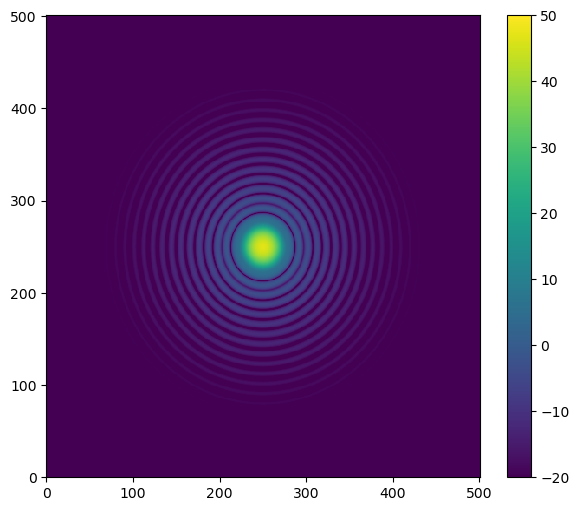

In [13]:
fig = plt.figure(figsize = (7,6))
plt.pcolor(np.log10(np.abs(E_co.reshape(501,-1)))*20,vmax = 50, vmin = -20)
plt.colorbar()


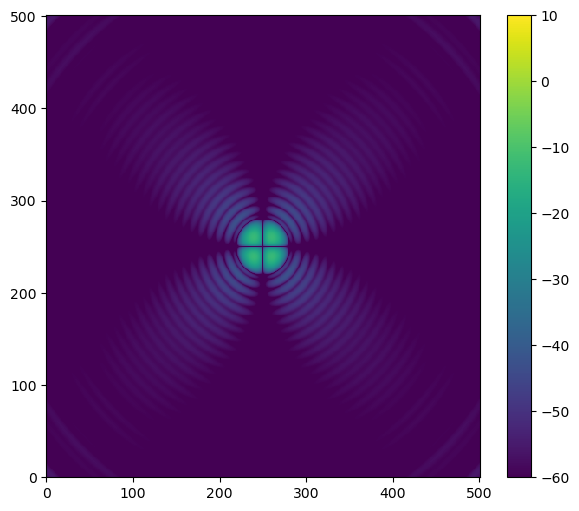

In [14]:
fig = plt.figure(figsize = (7,6))
plt.pcolor(np.log10(np.abs(E_cx.reshape(501,-1)))*20,vmax = 50-40, vmin = -20-40)
plt.colorbar()


In [15]:
import h5py as h5
def readh5(fname):
    name = fname.split('.')
    with h5.File(name[0]+'.h5','r') as f:
        co = f['co-polar'][:,:]
        cx = f['cx-polar'][:,:]
        Az = f['Az'][:]
        El = f['El'][:]
    return Az, El, co, cx


In [16]:
Az, El, grasp_co,grasp_cx = readh5('output/_H5/Lens1_POPO_nostop_GaussianBeam_force_farGHz.h5')
#Az, El, grasp_co_2,grasp_cx_2 = readh5('output/_H5/Lens1_POPO_nostop_GaussianBeamGHz.h5')
print(20*np.log10(np.abs(grasp_co).max())- 20*np.log10(np.abs(E_co).max()))


-3.0282945374437986e-05


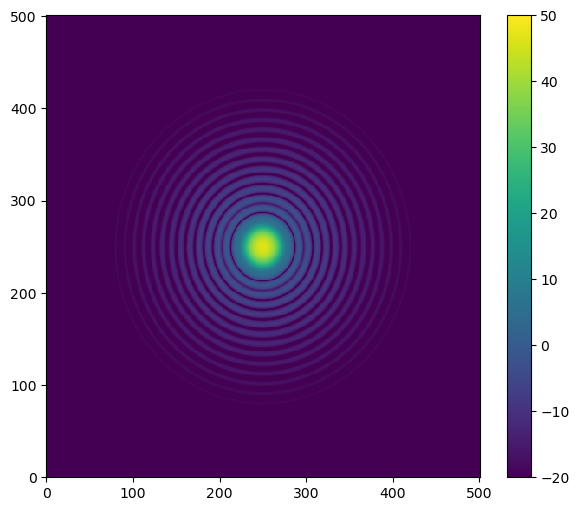

In [17]:
fig = plt.figure(figsize = (7,6))
plt.pcolor(np.log10(np.abs(grasp_co.reshape(501,-1)))*20,vmax = 50, vmin = -20)
plt.colorbar()


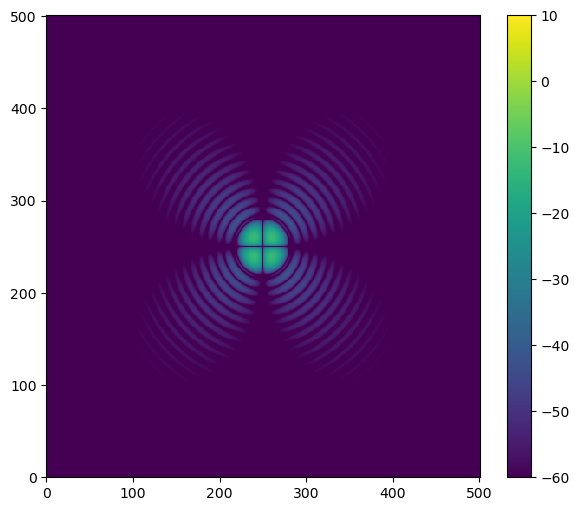

In [18]:
fig = plt.figure(figsize = (7,6))
plt.pcolor(np.log10(np.abs(grasp_cx.reshape(501,-1)))*20,vmax = 50-40, vmin = -20-40)
plt.colorbar()


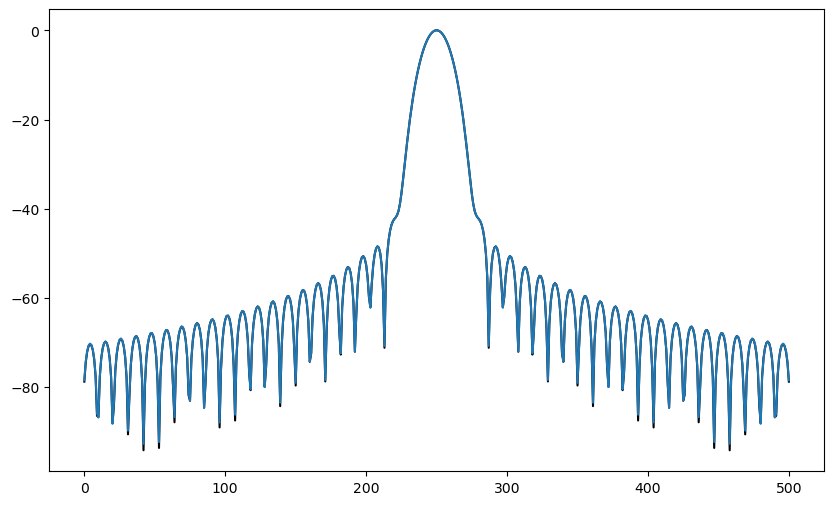

In [19]:
fig  =  plt.figure(figsize= (10,6))
plt.plot(np.log10(np.abs(grasp_co.reshape(501,-1)[250,:])/np.abs(grasp_co.reshape(501,-1)[250,:]).max())*20,'k-')
plt.plot(np.log10(np.abs(E_co.reshape(501,-1)[250,:])/np.abs(E_co.reshape(501,-1)[250,:]).max())*20,'-')


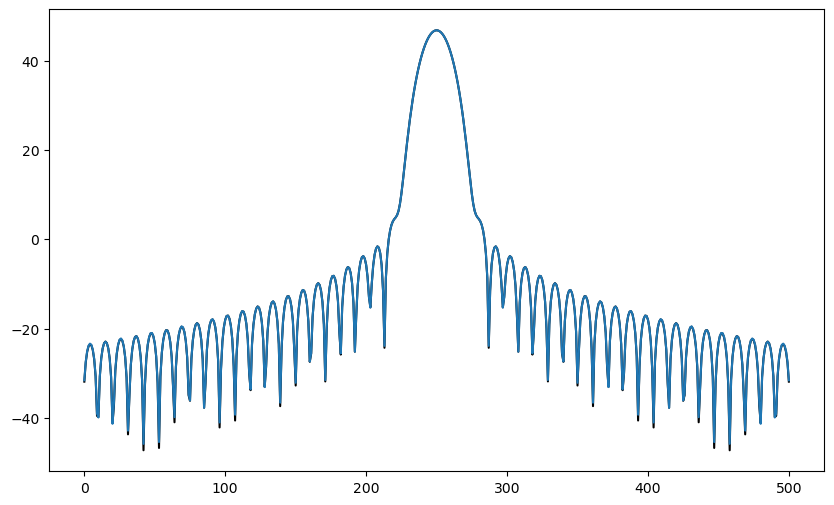

In [20]:
fig  =  plt.figure(figsize= (10,6))
plt.plot(np.log10(np.abs(grasp_co.reshape(501,-1)[250,:]))*20,'k-')
plt.plot(np.log10(np.abs(E_co.reshape(501,-1)[250,:])**2)*10,'-')


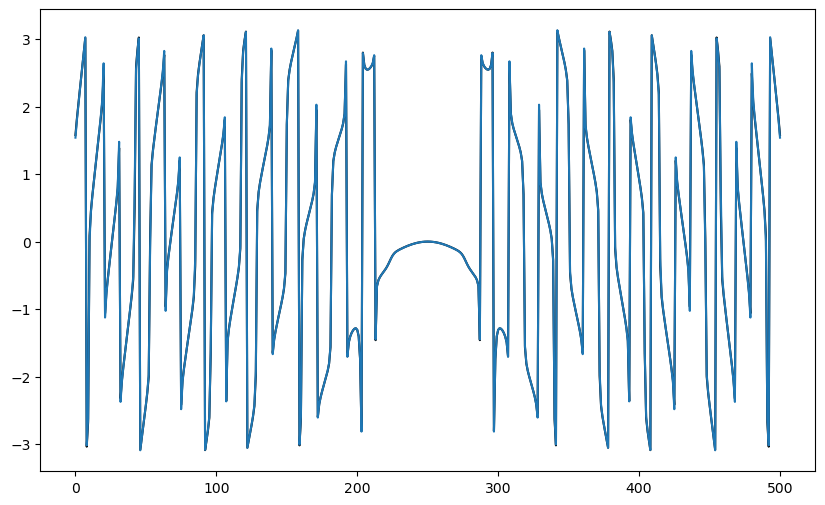

In [21]:
fig  =  plt.figure(figsize= (10,6))
plt.plot(np.angle(grasp_co.reshape(501,-1)[250,:]/grasp_co.reshape(501,-1)[250,250]),'k-')
plt.plot(np.angle(E_co.reshape(501,-1)[250,:]/E_co.reshape(501,-1)[250,250]),'-')


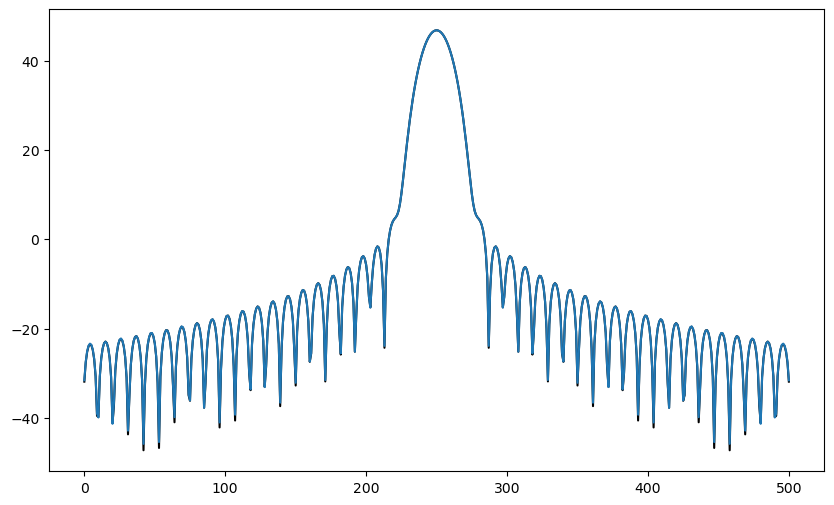

In [22]:
fig  =  plt.figure(figsize= (10,6))
plt.plot(np.log10(np.abs(grasp_co.reshape(501,-1)[250,:]))*20,'k-')
plt.plot(np.log10(np.abs(E_co.reshape(501,-1)[250,:])**2)*10,'-')


In [23]:
G_co = grasp_co.reshape(501,-1).T/grasp_co.reshape(501,-1)[250,250]
H_co = E_co.reshape(501,-1).T/E_co.reshape(501,-1)[250,250]


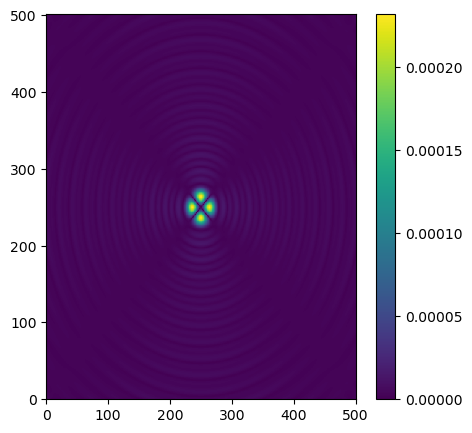

In [24]:
G_co = grasp_co.reshape(501,-1)/grasp_co.reshape(501,-1)[250,250]
H_co = E_co.reshape(501,-1)/E_co.reshape(501,-1)[250,250]
err = H_co-G_co
fig = plt.figure(figsize=(5,5))
plt.pcolor(np.abs(err))
plt.colorbar()


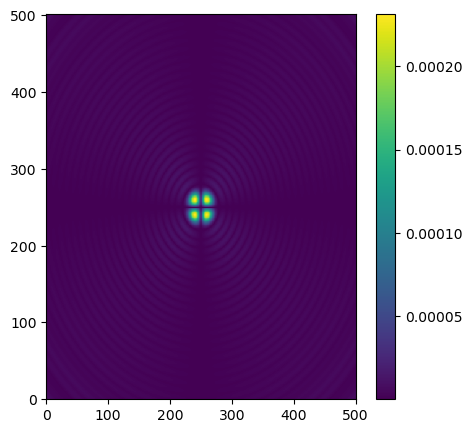

In [25]:
G_cx = grasp_cx.reshape(501,-1)/grasp_co.reshape(501,-1)[250,250]
H_cx = E_cx.reshape(501,-1)/E_co.reshape(501,-1)[250,250]
err = G_cx-H_cx
fig = plt.figure(figsize=(5,5))
plt.pcolor(np.abs(err))
plt.colorbar()


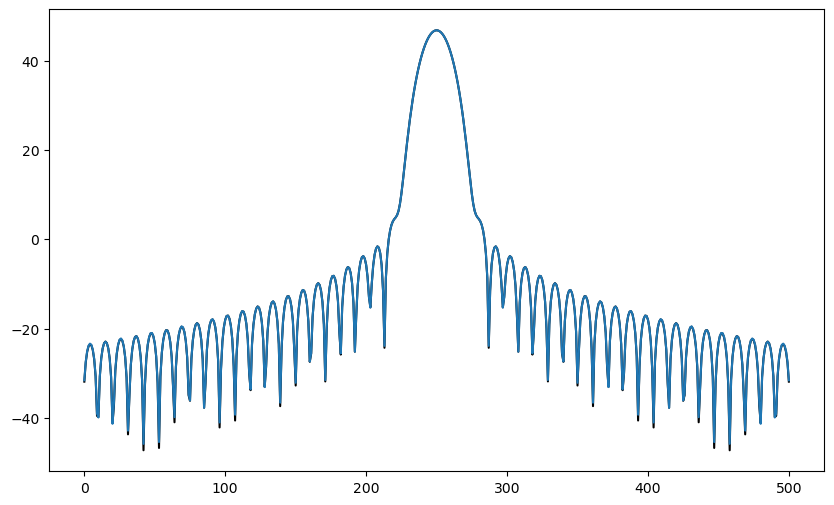

In [26]:
fig  =  plt.figure(figsize= (10,6))
plt.plot(np.log10(np.abs(grasp_co.reshape(501,-1)[250,:]))*20,'k-')
plt.plot(np.log10(np.abs(E_co.reshape(501,-1)[250,:])**2)*10,'-')


(-80.0, 0.0)

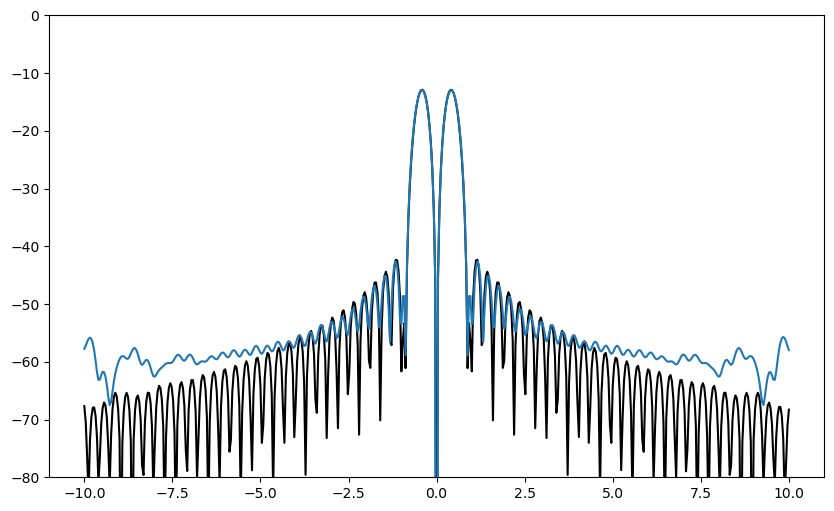

In [27]:
fig  =  plt.figure(figsize= (10,6))
plt.plot(center_grd.x,np.log10(np.abs(np.diagonal(grasp_cx.reshape(501,-1))))*20,'k-')
plt.plot(center_grd.x,np.log10(np.abs(np.diagonal(E_cx.reshape(501,-1).T)))*20,'-')
plt.ylim([-80,0])
#plt.xlim([-5,5])


(-80.0, 0.0)

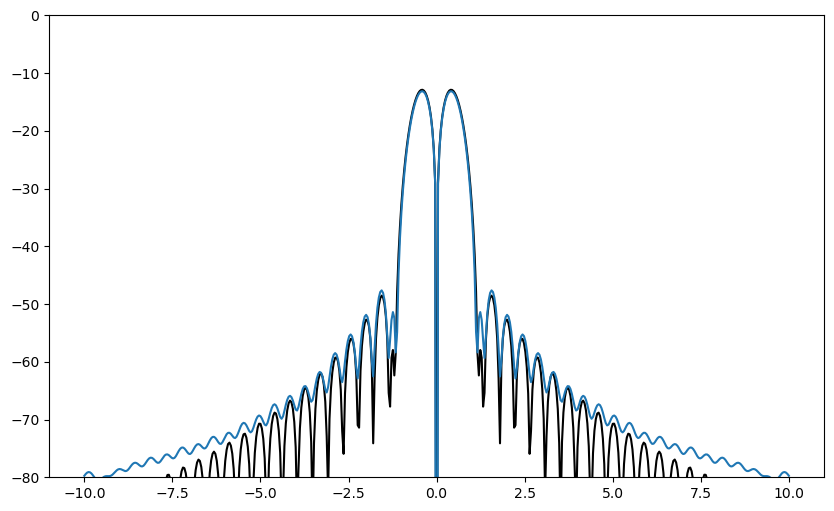

In [28]:
fig  =  plt.figure(figsize= (10,6))
plt.plot(center_grd.x,np.log10(np.abs(grasp_cx.reshape(501,-1)[240,:]))*20,'k-')
plt.plot(center_grd.x,np.log10(np.abs((E_cx.reshape(501,-1).T)[240-2,:]))*20,'-')
plt.ylim([-80,0])


(-2.0, 2.0)

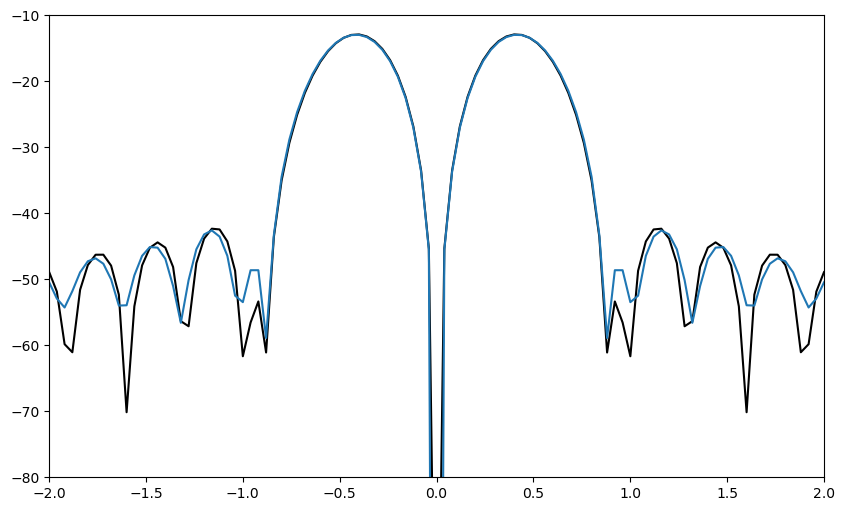

In [29]:
fig  =  plt.figure(figsize= (10,6))
plt.plot(center_grd.x,np.log10(np.abs(np.diagonal(grasp_cx.reshape(501,-1))))*20,'k-')
plt.plot(center_grd.x,np.log10(np.abs(np.diagonal(np.flip(E_cx.reshape(501,-1),axis=-1))))*20,'-')
plt.ylim([-80,-10])
plt.xlim([-2,2])


(-5.0, 5.0)

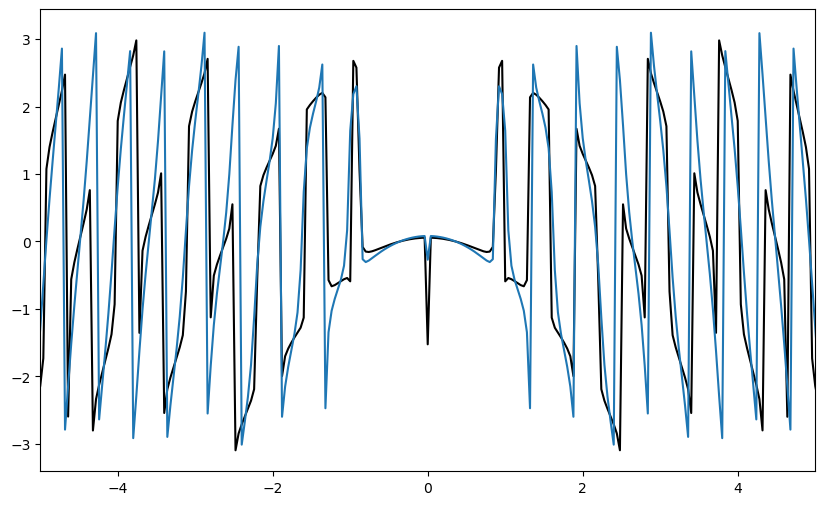

In [30]:
fig  =  plt.figure(figsize= (10,6))
plt.plot(center_grd.x,(np.angle(np.diagonal(grasp_cx.reshape(501,-1))/grasp_cx.reshape(501,-1)[241,241])),'k-')
plt.plot(center_grd.x,(np.angle(np.diagonal(E_cx.reshape(501,-1))/E_cx.reshape(501,-1)[241,241])),'-')

plt.xlim([-5,5])


In [31]:
np.array([10+1j*11])*np.array([10-1j*11])


array([221.+0.j])

In [32]:
np.array([10+1j*21,10+1j*21])*np.array([5,1])


array([50.+105.j, 10. +21.j])